<a href="https://colab.research.google.com/github/SuzyAdel/Machine_TranslatioN/blob/main/Seq2Seq%26Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load & Explore Dataset

---



In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import matplotlib.pyplot as plt

# Path to your dataset (adjust if needed)
file_path = '/content/drive/MyDrive/MT_Data/english-arabic-dataset.txt'

# Load first 10,000 lines
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()[:10000]

print(f"Total samples loaded: {len(lines)}")

Total samples loaded: 10000


In [26]:
# Separate English and Arabic sentences
eng_sentences = []
arb_sentences = []

for line in lines:
    eng, arb = line.strip().split('\t')
    eng_sentences.append(eng)
    arb_sentences.append(arb)

# Print 5 samples
for i in range(5):
    print(f"ENGLISH: {eng_sentences[i]}")
    print(f"ARABIC : {arb_sentences[i]}")
    print('---')

ENGLISH: Hi.
ARABIC : مرحبًا.
---
ENGLISH: Run!
ARABIC : اركض!
---
ENGLISH: Help!
ARABIC : النجدة!
---
ENGLISH: Jump!
ARABIC : اقفز!
---
ENGLISH: Stop!
ARABIC : قف!
---


In [27]:
# Sentence length analysis
eng_lengths = [len(sentence.split()) for sentence in eng_sentences]
arb_lengths = [len(sentence.split()) for sentence in arb_sentences]

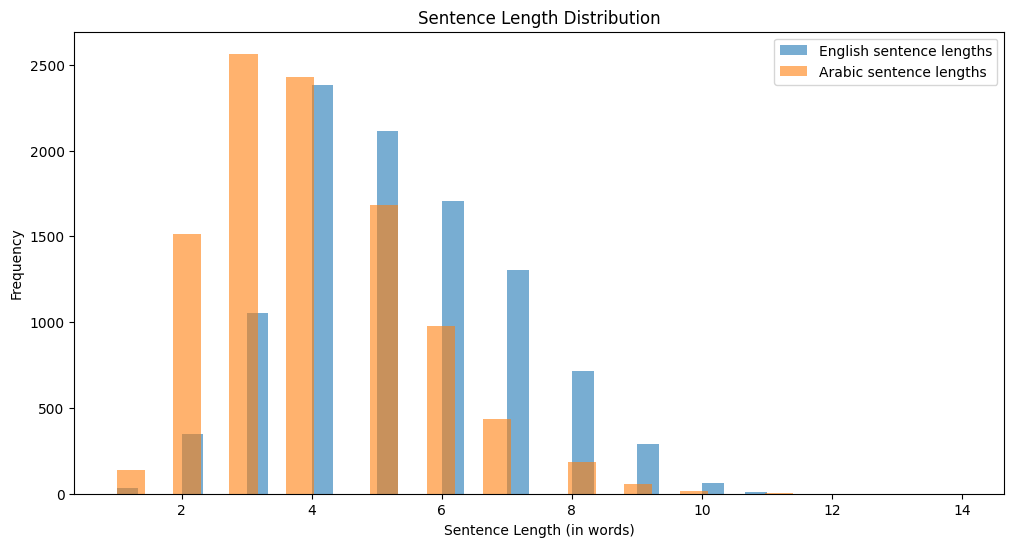

In [28]:
# Plot distributions
plt.figure(figsize=(12,6))
plt.hist(eng_lengths, bins=30, alpha=0.6, label='English sentence lengths')
plt.hist(arb_lengths, bins=30, alpha=0.6, label='Arabic sentence lengths')
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [29]:
# Check max lengths
print(f"Max English sentence length: {max(eng_lengths)}")
print(f"Max Arabic sentence length: {max(arb_lengths)}")

Max English sentence length: 11
Max Arabic sentence length: 14


## Preprocessing + Adding <start>, <end> Tokens

---


*   Lowercase
*   Strip whitespace
*   Remove punctuation
*   Remove digits if any
*   Remove double spaces
*   Start and end tokens added only on Arabic sentences.


In [30]:
# Function to clean and add special tokens
import re

def clean_sentence(sentence):
    # Lowercase
    sentence = sentence.lower().strip()
    # Remove punctuation and digits
    sentence = re.sub(r"[^a-zA-Zء-ي\s]", "", sentence)  # keeps Arabic & English letters and spaces only
    # Remove extra spaces
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence.strip()
def preprocess_arabic(sentence):
    sentence = clean_sentence(sentence)
    sentence = f"<start> {sentence} <end>"
    return sentence

def preprocess_english(sentence):
    sentence = clean_sentence(sentence)
    return sentence

# Apply cleaning
eng_sentences_cleaned = [preprocess_english(sent) for sent in eng_sentences]
arb_sentences_cleaned = [preprocess_arabic(sent) for sent in arb_sentences]

# Sanity check
for i in range(5):
    print(f"ENGLISH: {eng_sentences_cleaned[i]}")
    print(f"ARABIC : {arb_sentences_cleaned[i]}")
    print("---")

ENGLISH: hi
ARABIC : <start> مرحبا <end>
---
ENGLISH: run
ARABIC : <start> اركض <end>
---
ENGLISH: help
ARABIC : <start> النجدة <end>
---
ENGLISH: jump
ARABIC : <start> اقفز <end>
---
ENGLISH: stop
ARABIC : <start> قف <end>
---


## Tokenization with OOV handling and padding

---


In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# English tokenizer
eng_tokenizer = Tokenizer(oov_token="<OOV>")
eng_tokenizer.fit_on_texts(eng_sentences_cleaned)
eng_tensor = eng_tokenizer.texts_to_sequences(eng_sentences_cleaned)

# Arabic tokenizer
arb_tokenizer = Tokenizer(oov_token="<OOV>")
arb_tokenizer.fit_on_texts(arb_sentences_cleaned)
arb_tensor = arb_tokenizer.texts_to_sequences(arb_sentences_cleaned)

# Find max lengths
max_eng_length = max(len(seq) for seq in eng_tensor)
max_arb_length = max(len(seq) for seq in arb_tensor)

print(f"Max English sequence length: {max_eng_length}")
print(f"Max Arabic sequence length: {max_arb_length}")


Max English sequence length: 11
Max Arabic sequence length: 16


note : max length was 14 + 2 = 16

In [48]:
# Pad sequences
eng_tensor = pad_sequences(eng_tensor, maxlen=max_eng_length, padding='post')
arb_tensor = pad_sequences(arb_tensor, maxlen=max_arb_length, padding='post')

# Sanity check: print example
for i in range(3):
    print(f"English sequence: {eng_tensor[i]}")
    print(f"Arabic sequence: {arb_tensor[i]}")
    print("---")

print("Tokenization & padding step done bestie!")

English sequence: [874   0   0   0   0   0   0   0   0   0   0]
Arabic sequence: [  2 773   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
---
English sequence: [292   0   0   0   0   0   0   0   0   0   0]
Arabic sequence: [   2 2354    3    0    0    0    0    0    0    0    0    0    0    0
    0    0]
---
English sequence: [55  0  0  0  0  0  0  0  0  0  0]
Arabic sequence: [  2 900   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
---
Tokenization & padding step done bestie!


## Data Split - 75% train 25% test

In [49]:
from sklearn.model_selection import train_test_split

eng_train, eng_val, arb_train, arb_val = train_test_split(
    eng_tensor, arb_tensor, test_size=0.25, random_state=42
)

print(f"Train English shape: {eng_train.shape}")
print(f"Val English shape: {eng_val.shape}")
print(f"Train Arabic shape: {arb_train.shape}")
print(f"Val Arabic shape: {arb_val.shape}")


Train English shape: (7500, 11)
Val English shape: (2500, 11)
Train Arabic shape: (7500, 16)
Val Arabic shape: (2500, 16)


## Seq2Seq with RNN-based encoder-decoder

* Static LR = 0.0005

* Add ReduceLROnPlateau with factor=0.5, patience=3

* Add EarlyStopping with patience=5

* Train for max 50 epochs -- early stop/ just an upper limit  

* Batch size 64


2ND APPROACH
   
*   Add Dropout layers (with rates between 0.3–0.5)

* Add L2 weight regularization

* Use LearningRateScheduler to fine-tune

* Reduce batch size from 64 to something like 32



In [53]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [54]:
# Vocab sizes from tokenizer (replace with yours):
english_vocab_size = len(eng_tokenizer.word_index) + 1
arabic_vocab_size = len(arb_tokenizer.word_index) + 1

max_eng_len = 11
max_ar_len = 15

embedding_dim = 256
lstm_units = 512

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch > 20:
        return lr * 0.5
    return lr

In [55]:
# ----------- Encoder -----------
encoder_inputs = Input(shape=(max_eng_len,))
encoder_embed = Embedding(english_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_dropout = Dropout(0.4)(encoder_embed)
encoder_lstm = LSTM(
    lstm_units, return_state=True,
    kernel_regularizer=regularizers.l2(0.001),
    recurrent_regularizer=regularizers.l2(0.001)
)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_dropout)
encoder_states = [state_h, state_c]

# ----------- Decoder -----------
decoder_inputs = Input(shape=(max_ar_len,))
decoder_embed = Embedding(arabic_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_dropout = Dropout(0.4)(decoder_embed)
decoder_lstm = LSTM(
    lstm_units, return_sequences=True, return_state=True,
    kernel_regularizer=regularizers.l2(0.001),
    recurrent_regularizer=regularizers.l2(0.001)
)
decoder_outputs, _, _ = decoder_lstm(decoder_dropout, initial_state=encoder_states)
decoder_dense = Dense(arabic_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# ----------- Model Definition -----------
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# ----------- Compile Model -----------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 11)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 11, 256)        │        916,224 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 15, 256)        │      2,245,888 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 11, 256)        │              0 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_9 (NotEqual)    │ (None, 11)             │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 15, 256)        │              0 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 512), (None,   │      1,574,912 │ dropout[0][0],         │
│                           │ 512), (None, 512)]     │                │ not_equal_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, 15, 512),      │      1,574,912 │ dropout_1[0][0],       │
│                           │ (None, 512), (None,    │                │ lstm_6[0][1],          │
│                           │ 512)]                  │                │ lstm_6[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 15, 8773)       │      4,500,549 │ lstm_7[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,812,485 (41.25 MB)

 Trainable params: 10,812,485 (41.25 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [58]:
# Prepare data for decoder
train_arb_in = arb_train[:, :-1]
train_ar_out = arb_train[:, 1:]
val_ar_in = arb_val[:, :-1]
val_ar_out = arb_val[:, 1:]

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
lr_schedule = LearningRateScheduler(scheduler)

In [59]:
val_ar_in = arb_val[:, :-1]
val_ar_out = arb_val[:, 1:]
# Train the model with reduced batch size
history = model.fit(
    [train_eng, train_arb_in],
    train_ar_out,
    validation_data=([val_eng, val_ar_in], val_ar_out),
    batch_size=32,
    epochs=50,
    callbacks=[reduce_lr, early_stop, lr_schedule]
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.3102 - loss: 7.7150 - val_accuracy: 0.1393 - val_loss: 5.5020 - learning_rate: 5.0000e-04
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.1395 - loss: 5.2053 - val_accuracy: 0.1400 - val_loss: 5.4204 - learning_rate: 5.0000e-04
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.1407 - loss: 4.9969 - val_accuracy: 0.1424 - val_loss: 5.3587 - learning_rate: 5.0000e-04
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.1433 - loss: 4.8032 - val_accuracy: 0.1443 - val_loss: 5.3710 - learning_rate: 5.0000e-04
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.1451 - loss: 4.6196 - val_accuracy: 0.1452 - val_loss: 5.3646 - learning_rate: 5.0000e-04
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.1457 - loss: 4.4899 - val_accuracy: 0.1489 - val_loss: 5.3477 - learning_rate: 5.0000e-04
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/ste

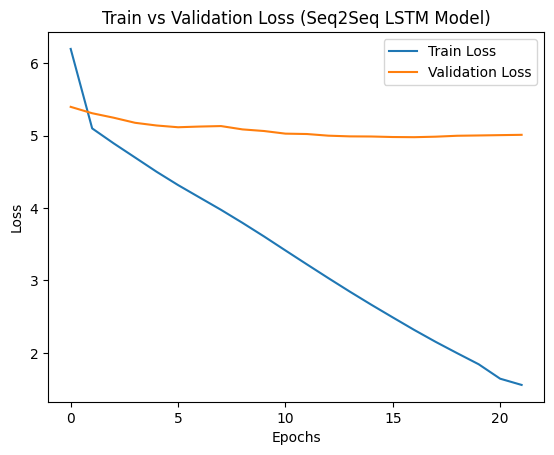

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss (Seq2Seq LSTM Model)')
plt.show()